In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import sklearn.model_selection as ms
import sklearn.metrics
from xgboost import XGBRegressor
import sklearn.model_selection as GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import VotingRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.model_selection import RandomizedSearchCV

In [61]:
train_df = pd.read_csv('house_prices_train.csv')
test_df = pd.read_csv('house_prices_test.csv')

In [62]:
train_df.head()

,ID,Bathrooms,Bedrooms,Erf Size,Garages,ID.1,Listing Date,Price,Type of Property,Location
0,0,4.0,4.0,NaN,2.0,1003,2019-10-28,4299000.0,House,"lat: 51.5073509,long: -0.1277583"
1,1,2.0,3.0,1 733 m²,2.0,1011,2019-06-05,2800000.0,House,"lat: 51.5073509,long: -0.1277583"
2,2,2.0,3.0,987 m²,1.0,1016,2019-10-31,980000.0,House,"lat: 51.5073509,long: -0.1277583"
3,3,2.0,3.0,1 539 m²,2.0,1019,2019-10-14,1795000.0,House,"lat: 51.5073509,long: -0.1277583"
4,4,2.0,3.0,70 m²,NaN,1029,2019-10-02,837780.0,House,"lat: 51.5073509,long: -0.1277583"


In [63]:
test_df.head()

,ID,Bathrooms,Bedrooms,Erf Size,Garages,ID.1,Listing Date,Price,Type of Property,Location
0,0,2.0,2.0,70 m²,NaN,4001,2019-06-03,R 645 000,Apartment / Flat,"lat: 51.5073509,long: -0.1277583"
1,1,1.0,2.0,91 m²,NaN,4002,2019-02-05,R 670 000,Townhouse,"lat: 51.5073509,long: -0.1277583"
2,2,2.0,2.0,72 m²,NaN,4003,2019-05-03,R 799 000,Townhouse,"lat: 51.5073509,long: -0.1277583"
3,3,4.0,4.0,265 m²,2.0,4007,2019-02-12,R 3 990 000,House,"lat: 51.5073509,long: -0.1277583"
4,4,2.0,3.0,213 m²,2.0,4016,2018-08-07,R 2 030 000,Townhouse,"lat: 51.5073509,long: -0.1277583"


In [64]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739 entries, 0 to 738
Data columns (total 10 columns):
ID                  739 non-null int64
Bathrooms           637 non-null float64
Bedrooms            718 non-null float64
Erf Size            578 non-null object
Garages             450 non-null float64
ID.1                739 non-null int64
Listing Date        739 non-null object
Price               737 non-null float64
Type of Property    739 non-null object
Location            739 non-null object
dtypes: float64(4), int64(2), object(4)
memory usage: 57.9+ KB


In [65]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 10 columns):
ID                  150 non-null int64
Bathrooms           119 non-null float64
Bedrooms            139 non-null float64
Erf Size            82 non-null object
Garages             73 non-null float64
ID.1                150 non-null int64
Listing Date        150 non-null object
Price               150 non-null object
Type of Property    150 non-null object
Location            150 non-null object
dtypes: float64(3), int64(2), object(5)
memory usage: 11.8+ KB


### Data Pre-processing and cleaning

In [66]:
# Set ID as index
train_df.set_index('ID', inplace=True)
test_df.set_index('ID', inplace=True)

In [67]:
# Check if there are values in acres for 'Erf Size'

erf_train_acres_index = train_df[['acres' in str(i) for i in train_df['Erf Size']]].index.values
erf_test_acres_index = test_df[['acres' in str(i) for i in test_df['Erf Size']]].index.values

print(erf_test_acres_index)
print(erf_train_acres_index)

[36 88]
[718]


In [68]:
train_df['Erf Size'] = [''.join(str(i).split()[:-1]) for i in train_df['Erf Size']]
test_df['Erf Size'] = [''.join(str(i).split()[:-1]) for i in test_df['Erf Size']]

In [69]:
#Percentages of missing values
print('Train df:\n',(train_df.isna().sum()/len(train_df))*100)
print('\nTest df:\n',(test_df.isna().sum()/len(test_df))*100)

Train df:
 Bathrooms           13.802436
Bedrooms             2.841678
Erf Size             0.000000
Garages             39.106901
ID.1                 0.000000
Listing Date         0.000000
Price                0.270636
Type of Property     0.000000
Location             0.000000
dtype: float64

Test df:
 Bathrooms           20.666667
Bedrooms             7.333333
Erf Size             0.000000
Garages             51.333333
ID.1                 0.000000
Listing Date         0.000000
Price                0.000000
Type of Property     0.000000
Location             0.000000
dtype: float64


In [70]:
for i, r in train_df.iterrows():
    if r['Erf Size'] == '':
        train_df.set_value(i, 'Erf Size', 0.0)
    else:
        train_df.set_value(i, 'Erf Size', float(r['Erf Size']))
        
train_df['Erf Size'] = pd.to_numeric(train_df['Erf Size'])

/home/explore/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/explore/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """


In [12]:
for i, r in test_df.iterrows():
    if r['Erf Size'] == '':
        test_df.set_value(i, 'Erf Size', 0.0)
    else:
        test_df.set_value(i, 'Erf Size', float(r['Erf Size']))
        
test_df['Erf Size'] = pd.to_numeric(test_df['Erf Size'])

/home/explore/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """
/home/explore/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 739 entries, 0 to 738
Data columns (total 9 columns):
Bathrooms           637 non-null float64
Bedrooms            718 non-null float64
Erf Size            739 non-null float64
Garages             450 non-null float64
ID.1                739 non-null int64
Listing Date        739 non-null object
Price               737 non-null float64
Type of Property    739 non-null object
Location            739 non-null object
dtypes: float64(5), int64(1), object(3)
memory usage: 77.7+ KB


In [14]:
train_cols_with_missing = [col for col in train_df.columns if train_df[col].isnull().any()]

imputer_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed_mean_train = pd.DataFrame(imputer_mean.fit_transform(train_df[train_cols_with_missing]))
imputed_mean_train.columns = train_cols_with_missing

In [15]:
train_df[train_cols_with_missing] = imputed_mean_train
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 739 entries, 0 to 738
Data columns (total 9 columns):
Bathrooms           739 non-null float64
Bedrooms            739 non-null float64
Erf Size            739 non-null float64
Garages             739 non-null float64
ID.1                739 non-null int64
Listing Date        739 non-null object
Price               739 non-null float64
Type of Property    739 non-null object
Location            739 non-null object
dtypes: float64(5), int64(1), object(3)
memory usage: 77.7+ KB


In [16]:
test_cols_with_missing = [col for col in test_df.columns if test_df[col].isnull().any()]

imputer_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed_mean_test = pd.DataFrame(imputer_mean.fit_transform(test_df[test_cols_with_missing]))
imputed_mean_test.columns = test_cols_with_missing
test_df[test_cols_with_missing] = imputed_mean_test
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 149
Data columns (total 9 columns):
Bathrooms           150 non-null float64
Bedrooms            150 non-null float64
Erf Size            150 non-null float64
Garages             150 non-null float64
ID.1                150 non-null int64
Listing Date        150 non-null object
Price               150 non-null object
Type of Property    150 non-null object
Location            150 non-null object
dtypes: float64(4), int64(1), object(4)
memory usage: 16.7+ KB


In [17]:
test_df['Price'] = [float(''.join(str(i).split()[1:])) for i in test_df['Price']]


In [18]:
test_df['Erf Size'].iloc[erf_test_acres_index].values[0]*4046.86

10117.15

In [19]:
train_df.set_value(erf_train_acres_index[0], 'Erf Size', train_df['Erf Size'].iloc[erf_train_acres_index].values[0]*4046.86)
test_df.set_value(erf_test_acres_index[0], 'Erf Size', test_df['Erf Size'].iloc[erf_test_acres_index].values[0]*4046.86)
test_df.set_value(erf_test_acres_index[1], 'Erf Size', test_df['Erf Size'].iloc[erf_test_acres_index].values[1]*4046.86)

/home/explore/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """Entry point for launching an IPython kernel.
/home/explore/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/home/explore/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until


,Bathrooms,Bedrooms,Erf Size,Garages,ID.1,Listing Date,Price,Type of Property,Location
ID,,,,,,,,,
0,2.0,2.0,70.0,2.219178,4001,2019-06-03,645000.0,Apartment / Flat,"lat: 51.5073509,long: -0.1277583"
1,1.0,2.0,91.0,2.219178,4002,2019-02-05,670000.0,Townhouse,"lat: 51.5073509,long: -0.1277583"
2,2.0,2.0,72.0,2.219178,4003,2019-05-03,799000.0,Townhouse,"lat: 51.5073509,long: -0.1277583"
3,4.0,4.0,265.0,2.000000,4007,2019-02-12,3990000.0,House,"lat: 51.5073509,long: -0.1277583"
4,2.0,3.0,213.0,2.000000,4016,2018-08-07,2030000.0,Townhouse,"lat: 51.5073509,long: -0.1277583"
...,...,...,...,...,...,...,...,...,...
145,1.0,2.0,2000.0,2.219178,4572,2019-07-02,2500000.0,House,"lat: 51.5073509,long: -0.1277583"
146,2.0,4.0,0.0,2.000000,4575,2017-10-17,1300000.0,House,"lat: 51.5073509,long: -0.1277583"
147,1.0,2.0,0.0,2.219178,4580,2017-11-29,1195000.0,Townhouse,"lat: 51.5073509,long: -0.1277583"


In [20]:
combined_df = pd.concat([train_df, test_df])
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 149
Data columns (total 9 columns):
Bathrooms           889 non-null float64
Bedrooms            889 non-null float64
Erf Size            889 non-null float64
Garages             889 non-null float64
ID.1                889 non-null int64
Listing Date        889 non-null object
Price               889 non-null float64
Type of Property    889 non-null object
Location            889 non-null object
dtypes: float64(5), int64(1), object(3)
memory usage: 69.5+ KB


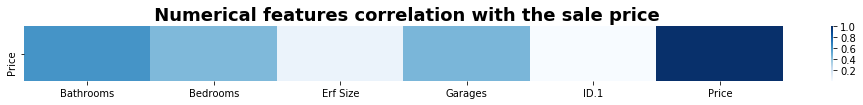

In [21]:
num = combined_df.select_dtypes(exclude='object')
numcorr = num.corr()
f,ax = plt.subplots(figsize=(17,1))
sns.heatmap(numcorr.sort_values(by=['Price'], ascending=False).head(1), cmap='Blues')
plt.title(" Numerical features correlation with the sale price", weight='bold', fontsize=18)
plt.show()

In [22]:
Num = numcorr['Price'].sort_values(ascending=False).head(10).to_frame()

cm = sns.light_palette("cyan", as_cmap=True)

s = Num.style.background_gradient(cmap=cm)
s

,Price
Price,1
Bathrooms,0.614928
Garages,0.462844
Bedrooms,0.451173
Erf Size,0.0615332
ID.1,0.0017718


#### Encoding categorical columns

In [23]:
print(train_df['Type of Property'].unique())
print('\n',test_df['Type of Property'].unique())

['House' 'Townhouse' 'Apartment / Flat']

 ['Apartment / Flat' 'Townhouse' 'House']


In [24]:
print(train_df.Location.unique())
print(test_df.Location.unique())

['lat: 51.5073509,long: -0.1277583']
['lat: 51.5073509,long: -0.1277583']


In [25]:
train_df.drop('Location', axis=1, inplace=True)
test_df.drop('Location', axis=1, inplace=True)

In [26]:
# Converting the 'Listing Date' column to datatime
train_df['Listing Date'] = pd.to_datetime(train_df['Listing Date'])
test_df['Listing Date'] = pd.to_datetime(test_df['Listing Date'])

In [27]:
dummy_train = pd.get_dummies(train_df['Type of Property'])
dummy_test = pd.get_dummies(test_df['Type of Property'])
train_df_dummied = pd.merge(train_df.reset_index(), dummy_train.reset_index(), how='inner', on='ID')
test_df_dummied = pd.merge(test_df.reset_index(), dummy_test.reset_index(), how='inner', on='ID')
train_df_dummied.drop(['Type of Property','ID'], axis=1, inplace=True)
test_df_dummied.drop(['Type of Property', 'ID'], axis=1, inplace=True)
train_df_dummied.set_index('ID.1', inplace=True)
test_df_dummied.set_index('ID.1', inplace=True)

In [28]:
train_df_dummied.head()

,Bathrooms,Bedrooms,Erf Size,Garages,Listing Date,Price,Apartment / Flat,House,Townhouse
ID.1,,,,,,,,,
1003,4.0,4.0,0.0,2.000000,2019-10-28,4299000.0,0,1,0
1011,2.0,3.0,1733.0,2.000000,2019-06-05,2800000.0,0,1,0
1016,2.0,3.0,987.0,1.000000,2019-10-31,980000.0,0,1,0
1019,2.0,3.0,1539.0,2.000000,2019-10-14,1795000.0,0,1,0
1029,2.0,3.0,70.0,2.086667,2019-10-02,837780.0,0,1,0


##### Drop columns with an insignificant correlation with Prices

In [29]:
y_train = train_df_dummied.Price
y_test = test_df_dummied.Price
X_train = train_df_dummied.drop(['Erf Size', 'Listing Date', 'Price'], axis=1)
X_test = test_df_dummied.drop(['Erf Size', 'Listing Date', 'Price'], axis=1)

In [30]:
X_train.head()

,Bathrooms,Bedrooms,Garages,Apartment / Flat,House,Townhouse
ID.1,,,,,,
1003,4.0,4.0,2.000000,0,1,0
1011,2.0,3.0,2.000000,0,1,0
1016,2.0,3.0,1.000000,0,1,0
1019,2.0,3.0,2.000000,0,1,0
1029,2.0,3.0,2.086667,0,1,0


### Modelling

In [44]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(X_train, y_train)
rf_preds = forest_model.predict(X_test)
print(mean_absolute_error(y_test, rf_preds))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.7min finished


785952.37133319


In [32]:
# xg_reg = XGBRegressor()
# xgparam_grid= {'learning_rate' : [0.01],'n_estimators':[2000, 3460, 4000],
#                                      'max_depth':[3], 'min_child_weight':[0,3,5],
#                                     'colsample_bytree':[0.5,0.7],
#                                      'reg_alpha':[0.0001,0.001,0.01,0.1,10,100],
#                                     'reg_lambda':[1,0.01,0.8,0.001,0.0001]}

# xg_grid= ms.GridSearchCV(xg_reg, param_grid=xgparam_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# xg_grid.fit(X_train,y_train)
# print(xg_grid.best_estimator_)
# print(xg_grid.best_score_)

xgb_model =XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=3, missing=None, n_estimators=4000,
             n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
             reg_alpha=0.001, reg_lambda=0.0001, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
xgb_model.fit(X_train, y_train, early_stopping_rounds=4, eval_set=[(X_test, y_test)], verbose=False)
xgb_preds = xgb_model.predict(X_test)
print(mean_absolute_error(y_test, xgb_preds))

685471.4929166667


/home/explore/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/explore/anaconda3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [33]:
ridge = Ridge()
parameters = {'alpha':[x for x in range(1,101)]}

ridge_reg = ms.GridSearchCV(ridge, param_grid=parameters, scoring='neg_mean_squared_error', cv=15)
ridge_reg.fit(X_train,y_train)
print("The best value of Alpha is: ",ridge_reg.best_params_['alpha'])
print("The best score achieved with Alpha=14 is: ",np.sqrt(-ridge_reg.best_score_))
ridge = Ridge(alpha=ridge_reg.best_params_['alpha'])
ridge.fit(X_train,y_train)
ridge_model = Ridge(alpha=ridge_reg.best_params_['alpha'])
ridge_model.fit(X_train,y_train)
ridge_preds = ridge_model.predict(X_test)
print('MAE:',mean_absolute_error(y_test, ridge_preds))

The best value of Alpha is:  26
The best score achieved with Alpha=14 is:  1656619.9119183242
MAE: 883268.2860177314


In [34]:
parameters = {'alpha':[0.0001,0.0009,0.001,0.002,0.003,0.01,0.1,1,10,100]}

lasso = Lasso(tol=0.04)
lasso_reg = ms.GridSearchCV(lasso, param_grid=parameters, scoring='neg_mean_squared_error', cv=15)
lasso_reg.fit(X_train,y_train)

print('The best value of Alpha is: ',lasso_reg.best_params_)
lasso_model = Lasso(alpha=lasso_reg.best_params_['alpha'], tol=0.04)
lasso_model.fit(X_train,y_train)
lasso_preds = lasso_model.predict(X_test)
print('MAE:',mean_absolute_error(y_test, lasso_preds))

The best value of Alpha is:  {'alpha': 100}
MAE: 894529.7208746431


In [35]:
alphas =  [10,1,0.1,0.01,0.001,0.002,0.003,0.004,0.005,0.00054255]
l1ratio = [0.1, 0.3,0.5, 0.9, 0.95, 0.99, 1]

elastic_cv = ElasticNetCV(cv=5, max_iter=1e7, alphas=alphas,  l1_ratio=l1ratio)

elasticmod = elastic_cv.fit(X_train, y_train.ravel())
ela_pred=elasticmod.predict(X_test)
print('Root Mean Square Error test = ' + str(mean_absolute_error(y_test, ela_pred)))
print(elastic_cv.alpha_)

Root Mean Square Error test = 890992.1217068132
1.0


In [46]:
vote_model = VotingRegressor([('Random_Forest', rf_random), ('Ridge', ridge_model), ('Lasso', lasso_model), ('Elastic', elastic_cv), ('XGBRegressor', xgb_model)])
vote = vote_model.fit(X_train, y_train.ravel())
vote_preds = vote.predict(X_test)

print('Root Mean Square Error test = ' + str(mean_absolute_error(y_test, vote_preds)))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.7min finished


Root Mean Square Error test = 831874.8610566761


In [49]:
stregr = StackingRegressor(regressors=[rf_random, elastic_cv,ridge_model, lasso_model, vote_model], 
                           meta_regressor=xgb_model, use_features_in_secondary=True
                          )

stack_model = stregr.fit(X_train, y_train.ravel())
stack_preds = stack_model.predict(X_test)

print('Root Mean Square Error test = ' + str(mean_absolute_error(y_test, stack_preds)))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.7min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.7min finished


Root Mean Square Error test = 899788.9870833333


In [81]:
final_submission = pd.DataFrame({
        "Id": X_test.index.values,
        "Price": [float(''.join(i.split()[1:])) for i in test_df.Price]
    })
final_submission.to_csv("final_submission2.csv", index=False)
final_submission.head()

,Id,Price
0,4001,645000.0
1,4002,670000.0
2,4003,799000.0
3,4007,3990000.0
4,4016,2030000.0


In [80]:
y_prices = [float(''.join(i.split()[1:])) for i in test_df.Price]
len(y_prices)

150